# Imports & basic configuration

In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/branch_full/deep_branching"
except:
    pass

import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from branch import Net
from galerkin import DGMNet
from bsde import BSDENet
import logging
from pynverse import inversefunc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
import torchaudio
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchaudio version: {torchaudio.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.11.0+cu113
torchaudio version: 0.11.0+cu113
torchvision version: 0.12.0+cu113


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Thu May 12 00:22:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.73       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:07:00.0  On |                  N/A |
| 30%   50C    P8    30W / 350W |    644MiB / 12288MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [4]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    **kwargs,
):
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)

    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "log/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "log/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "log/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "log/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

# 1-dimensional PDE

## Allen-Cahn

In [5]:
# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

dgm_deriv_map = np.array([0, 2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> second deriv
    """
    return .5 * y[1] + y[0] - y[0] ** 3

def phi_example(x):
    return -0.5 - 0.5 * torch.nn.Tanh()(-x[0] / 2)

def exact_example(t, x, T):
    return -0.5 - 0.5 * np.tanh(-x[0]/2 + 3*(T-t)/4)

t_lo, x_lo, x_hi, n = 0., -8., 8., 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 50 seconds; L1 error: 1.32E-03; L2 error: 4.68E-06; rel error: 2.49E-02.
fdb runtime: 0 seconds; total runtime: 50 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 45 seconds; L1 error: 1.13E-03; L2 error: 2.26E-06; rel error: 2.46E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 84 seconds; L1 error: 5.11E-03; L2 error: 5.22E-05; rel error: 1.08E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 23 seconds; L1 error: 1.11E-03; L2 error: 3.81E-06; rel error: 3.30E-02.
fdb runtime: 0 seconds; total runtime: 23 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 47 seconds; L1 error: 8.30E-04; L2 error: 1.39E-06; rel error: 1.20E-01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 81 seconds; L1 error: 4.86E-03; L2 error: 3.56E-05; rel error: 

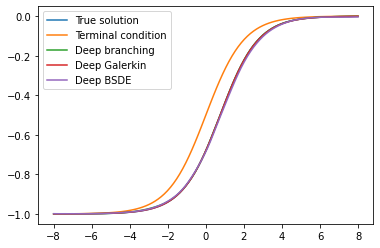

In [6]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Exponential nonlinearity

In [7]:
alpha = 10

# function definition
deriv_map = np.array([0, 1]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return torch.exp(-y[0]) - 2 * torch.exp(-2 * y[0]) + alpha * y[1]

dgm_deriv_map = np.array([0, 1, 2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return .5 * y[2] + torch.exp(-y[0]) - 2 * torch.exp(-2 * y[0]) + alpha * y[1]

def phi_example(x):
    return torch.log(1 + x[0] ** 2)

def exact_example(t, x, T):
    return np.log(1 + (x[0] + alpha * (T - t)) ** 2)

t_lo, x_lo, x_hi, n = 0., -4., 4., 1
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .05
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 25 seconds; L1 error: 1.04E-02; L2 error: 4.23E-04; rel error: 9.31E-01.
fdb runtime: 0 seconds; total runtime: 25 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 55 seconds; L1 error: 1.31E-02; L2 error: 2.72E-04; rel error: 7.20E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 85 seconds; L1 error: 1.36E-02; L2 error: 4.50E-04; rel error: 1.66E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 26 seconds; L1 error: 1.05E-02; L2 error: 3.52E-04; rel error: 8.11E-01.
fdb runtime: 0 seconds; total runtime: 26 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 56 seconds; L1 error: 9.59E-03; L2 error: 2.27E-04; rel error: 1.02E+00.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 86 seconds; L1 error: 1.03E-02; L2 error: 2.54E-04; rel error: 

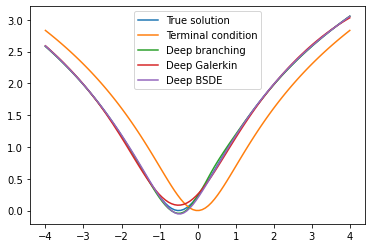

In [8]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="exponential",
                    branch_nb_states=1000, branch_nb_path_per_state=30000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Cosine nonlinearity

In [9]:
alpha = 10

# function definition
deriv_map = np.array([0, 1, 2, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    idx 3 -> forth deriv
    """
    return -.5 * y[2] + alpha * y[1] + y[0] - (y[2] / 12) ** 2 + torch.cos(math.pi * y[3] / 24)

dgm_deriv_map = np.array([0, 1, 2, 4]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    idx 3 -> forth deriv
    """
    return alpha * y[1] + y[0] - (y[2] / 12) ** 2 + torch.cos(math.pi * y[3] / 24)

def phi_example(x):
    return x[0]**4 + x[0]**3 - 36/47 * x[0]**2 - 24*36/47 * x[0] + 4 * (36/47)**2

def exact_example(t, x, T):
    xx = x[0] + alpha * (T - t)
    return xx**4 + xx**3 - 36/47 * xx**2 - 24*36/47 * xx + 4 * (36/47)**2

t_lo, x_lo, x_hi, n = 0., -5., 5., 4
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .04
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 77 seconds; L1 error: 1.09E+01; L2 error: 5.24E+02; rel error: 2.66E-01.
fdb runtime: 0 seconds; total runtime: 77 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 167 seconds; L1 error: 1.37E+01; L2 error: 5.98E+02; rel error: 3.30E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 75 seconds; L1 error: 1.14E+01; L2 error: 4.52E+02; rel error: 2.41E-01.
fdb runtime: 0 seconds; total runtime: 75 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 158 seconds; L1 error: 1.14E+02; L2 error: 1.50E+04; rel error: 1.16E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 82 seconds; L1 error: 1.15E+01; L2 error: 6.97E+02; rel error: 2.00E-01.
fdb runtime: 0 seconds; total runtime: 82 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken:

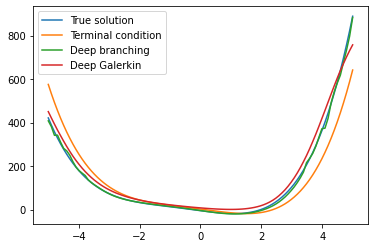

In [10]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, # seeds=[0], 
                    # disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, dgm_lr=1e-2, fname="cosine",
                    branch_nb_states=1000, branch_nb_path_per_state=2500,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Log nonlinearity

In [11]:
alpha = 10

# function definition
deriv_map = np.array([1, 2, 3]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> first deriv
    idx 1 -> second deriv
    idx 2 -> third deriv
    """
    return -.5 * y[1] + alpha * y[0] + torch.log(y[1]**2 + y[2]**2)

dgm_deriv_map = np.array([1, 2, 3]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> first deriv
    idx 1 -> second deriv
    idx 2 -> third deriv
    """
    return alpha * y[0] + torch.log(y[1]**2 + y[2]**2)

def phi_example(x):
    return torch.cos(x[0])

def exact_example(t, x, T):
    return np.cos(x[0] + alpha * (T-t))

t_lo, x_lo, x_hi, n = 0., -3., 3., 3
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .02
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 55 seconds; L1 error: 4.38E-03; L2 error: 3.59E-05; rel error: 1.31E-02.
fdb runtime: 0 seconds; total runtime: 55 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 92 seconds; L1 error: 1.27E-01; L2 error: 2.12E-02; rel error: 4.56E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 55 seconds; L1 error: 5.50E-03; L2 error: 4.35E-05; rel error: 3.49E-02.
fdb runtime: 0 seconds; total runtime: 55 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 91 seconds; L1 error: 6.08E-02; L2 error: 4.83E-03; rel error: 2.57E-01.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 58 seconds; L1 error: 5.13E-03; L2 error: 3.61E-05; rel error: 3.04E-02.
fdb runtime: 0 seconds; total runtime: 58 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Time taken: 9

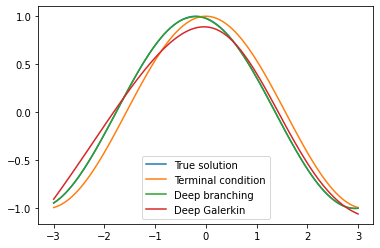

In [12]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, # seeds=[0], 
                    # disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="log",
                    branch_nb_states=1000, branch_nb_path_per_state=6000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000,
                    bsde_nb_states=1000, bsde_nb_time_intervals=5,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Merton problem

In [17]:
mu = .03
sigma = .1
gamma = .5
rho = .01

# TODO: how to deal with negative x and y[1] properly???

# function definition
deriv_map = np.array([0, 1, 2]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return -.5 * y[2] - (mu * y[1])**2 / (2 * sigma**2 * y[2]) + gamma * y[1].abs()**(1 - 1/gamma) / (1 - gamma) - rho * y[0]

dgm_deriv_map = np.array([0, 1, 2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return -(mu * y[1])**2 / (2 * sigma**2 * y[2]) + gamma * y[1].abs()**(1 - 1/gamma) / (1 - gamma) - rho * y[0]

def phi_example(x):
    return x[0].abs() ** (1 - gamma) / (1 - gamma)

def exact_example(t, x, T):
    nu = (2 * sigma**2 * gamma * rho - (1 - gamma) * mu**2) / (2 * sigma**2 * gamma**2)
    return x[0]**(1 - gamma) * (1 + (nu-1) * math.exp(-nu * (T - t)))**gamma / (nu**gamma * (1 - gamma))

t_lo, x_lo, x_hi, n = 0., 100., 200., 2
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .1
true = exact_example(t_lo, grid_d_dim, T).real
terminal = exact_example(T, grid_d_dim, T).real

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 42 seconds; L1 error: 9.15E-03; L2 error: 1.41E-04; rel error: 3.59E-04.
fdb runtime: 0 seconds; total runtime: 42 seconds.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 151 seconds; L1 error: 1.69E+00; L2 error: 2.89E+00; rel error: 6.66E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 41 seconds; L1 error: 1.28E-02; L2 error: 2.40E-04; rel error: 4.94E-04.
fdb runtime: 0 seconds; total runtime: 41 seconds.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 154 seconds; L1 error: 1.52E+00; L2 error: 2.38E+00; rel error: 5.90E-02.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 41 seconds; L1 error: 9.37E-03; L2 error: 1.39E-04; rel error: 3.66E-04.
fdb runtime: 0 seconds; total runtime: 41 seconds.
#### Starting deep BSDE method with seed 2 - 3 out of 10 times
Time taken: 154 seconds

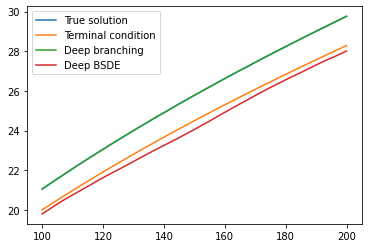

In [18]:
# with 2BSDE...
#
# Performance comparison, deep branching seems to have gradient problem, hence we use relu activation function
# Also, it doesn't work for DGM method because of possible zero second derivatives, so we disable it
#
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[2],
                    disable_galerkin=True, # verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="merton",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000, branch_activation="relu",
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4, y_lo=0, y_hi=100,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 2 - 1 out of 1 times
Patch 0: generation of samples take 27.776033639907837 seconds.


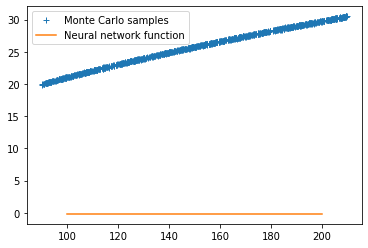

Patch 0: epoch 0 with loss 668.4889526367188


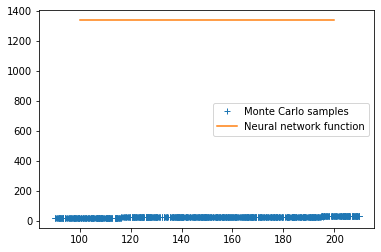

Patch 0: epoch 500 with loss 9.09229564666748


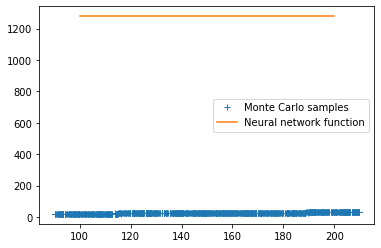

Patch 0: epoch 1000 with loss 9.092215538024902


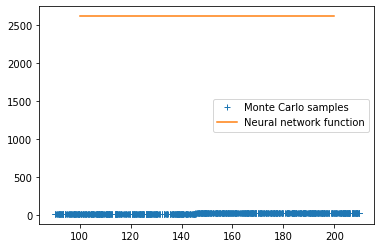

Patch 0: epoch 1500 with loss 9.092209815979004


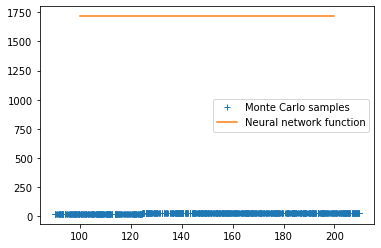

Patch 0: epoch 2000 with loss 9.092199325561523


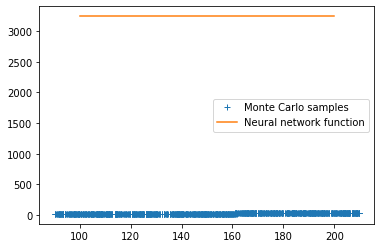

Patch 0: epoch 2500 with loss 9.092192649841309


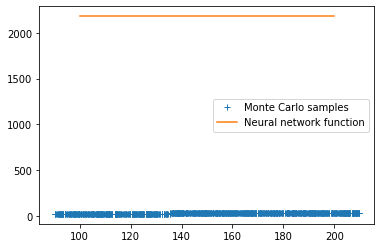

Patch 0: epoch 2999 with loss 9.092195510864258
Patch 0: training of neural network with 3000 epochs take 14.290551662445068 seconds.
Time taken: 42 seconds; L1 error: 2.16E+03; L2 error: 4.65E+06; rel error: 8.49E+01.
fdb runtime: 0 seconds; total runtime: 42 seconds.




######## Summary for deep branching method
runtime:        42
fdb runtime:    0
total runtime:  42
mean L1 error:  2.16E+03
std L1 error:   0.00E+00
mean L2 error:  4.65E+06
std L2 error:   0.00E+00
mean rel error: 8.49E+01
std rel error:  0.00E+00


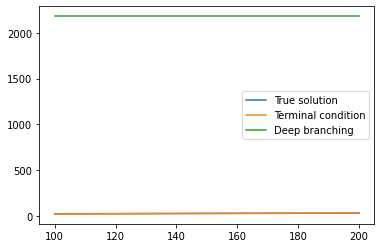

In [19]:
# Performance comparison, seems to have gradient problem when using tanh activation
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, seeds=[2],
                    disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000,
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=1000, # branch_activation="relu",
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Generalized burgers equation

In [20]:
def gen_fun_and_inv(n, eps, nu, u1, u2):
    if n <= 1/4 and (1/n) % 1 == 0:
        print("Infinity detected when calculating hypergeometric function, the calculation is not accurate!")
    if n == 1:
        fun = (
            lambda u:(
                2*nu/(u2-u1)*np.log((u2 - u)/(u - u1))
            )
        )
    elif n == 1/2:
        fun = (
            lambda u: (
                (2*nu)**2*(
                    (u2-u1)**(-2)*(1/(u-u1) - 1/(u2-u))
                    + 2*(u2-u1)**(-3)*np.log((u2-u)/(u-u1)))
            )
        )
    elif n == 1/3:
        fun = (
            lambda u: (
                (2*nu)**3*(
                    .5*(u2-u1)**(-3)*(1/(u-u1)**2 - 1/(u2-u)**2)
                    + 3*(u2-u1)**(-4)*(1/(u-u1) - 1/(u2-u))
                    + 6*(u2-u1)**(-5)*np.log((u2-u)/(u-u1)))
            )
        )
    else:
        fun = (lambda u:-(2*nu)**(1/n)*n*(u-u1)*((u2-u1)*(u-u1))**(-1/n)*special.hyp2f1(1/n,1-1/n,2-1/n, (u-u1)/(u2-u1))/(n-1))
    inv = (lambda xi: inversefunc(fun, y_values=xi, domain=[u1+eps,u2-eps]))
    return fun, inv


def gen_for_generalized_burgers(
    n=1,
    T=1.,
    u1=0.,
    u2=1.,
    nu=.5,
    eps=1e-6,
    eps_graph=1e-2,
    verbose=False
):
    neurons = 50
    nb_points = 10000
    lambd = (u1 + u2) / 2
    require_training = not(n == 1 or n == 2)
    fun, inv = gen_fun_and_inv(n=n, eps=eps, nu=nu, u1=u1, u2=u2)
    
    if require_training:
        torch.manual_seed(0)
        # neural network parameter
        inv_model = torch.nn.Sequential(
            torch.nn.BatchNorm1d(1, device=device),
            torch.nn.Linear(1, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, neurons, device=device),
            torch.nn.Tanh(),
            torch.nn.BatchNorm1d(neurons, device=device),
            torch.nn.Linear(neurons, 1, device=device),
        )

        # define the functions, x, and y
        x_for_fun = np.linspace(u1, u2, nb_points + 2)[1:-1]
        x_lo, x_hi = fun(u2-eps), fun(u1+eps)
        x = np.linspace(x_lo, x_hi, nb_points)
        y = torch.tensor(inv(x), dtype=torch.get_default_dtype(), device=device)
        x = torch.tensor(x, dtype=torch.get_default_dtype(), device=device).unsqueeze(dim=-1)

        # neural network training
        optimizer = torch.optim.Adam(inv_model.parameters(), lr=1e-2)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2000, 4000, 6000, 8000], gamma=0.5)
        loss_fun = torch.nn.MSELoss()
        inv_model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            loss = loss_fun(y, inv_model(x).squeeze())
            loss.backward()
            optimizer.step()
            scheduler.step()
            if epoch % 100 == 0 and verbose:
                print(f"Epoch {epoch}, loss = {loss}")
        inv_model.eval()

        # detach all model parameters to save memory
        for p in inv_model.parameters():
            p.requires_grad = False

        if verbose:
            # plot the graph
            plt.plot(x.cpu(), inv_model(x).detach().cpu(), label="NN approximation")
            plt.plot(x.cpu(), y.cpu(), label="true inverse")
            plt.legend()
            plt.show()
            print(f"The max difference is {(y.cpu() - inv_model(x).detach().cpu().squeeze()).abs().max()}.")

    # function definition
    deriv_map = np.array([0, 1, 2]).reshape(-1, 1)
    def f_example(y):
        """
        idx 0 -> no deriv
        idx 1 -> first deriv
        idx 2 -> second deriv
        """
        return (
            - y[0] * y[1]
            + nu * y[2] * n * y[1].abs()**(n-1) 
            - nu * y[2]
        )

    def phi_example(x):
        if n == 1:
            return u2 + (u1 - u2) / (1 + torch.exp((u1 - u2) * x[0] / (2 * nu)))
        elif n == 2:
            return u1 + (u2 - u1) * torch.sin(-x[0] / (2 * math.sqrt(2 * nu)))**2
        else:
            return inv_model(x.T).squeeze(dim=-1)

    def exact_example(t, x, T):
        xi = x[0] - lambd * (T - t)
        if n == 1:
            return u2 + (u1 - u2) / (1 + np.exp((u1 - u2) * xi / (2 * nu)))
        elif n == 2:
            return u1 + (u2 - u1) * np.sin(-xi / (2 * math.sqrt(2 * nu)))**2
        else:
            return inv(xi)

    t_lo, x_lo, x_hi = 0., -10., 10.
    # best view for waterfall, eps < eps_graph
    x_lo, x_hi = fun(u2-eps_graph) + lambd * T, fun(u1+eps_graph)
    grid = np.linspace(x_lo, x_hi, 100)
    grid_d_dim = np.expand_dims(grid, axis=0)
    grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

    true = exact_example(t_lo, grid_d_dim, T)
    terminal = exact_example(T, grid_d_dim, T)
    return grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, f_example, deriv_map, phi_example

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 34 seconds; L1 error: 9.04E-04; L2 error: 1.28E-06; rel error: 5.08E-03.
fdb runtime: 0 seconds; total runtime: 34 seconds.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 34 seconds; L1 error: 8.44E-04; L2 error: 1.20E-06; rel error: 4.90E-03.
fdb runtime: 0 seconds; total runtime: 34 seconds.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 33 seconds; L1 error: 7.85E-04; L2 error: 9.39E-07; rel error: 4.34E-03.
fdb runtime: 0 seconds; total runtime: 33 seconds.


#### Starting deep branching method with seed 3 - 4 out of 10 times
Time taken: 33 seconds; L1 error: 9.33E-04; L2 error: 1.46E-06; rel error: 5.09E-03.
fdb runtime: 0 seconds; total runtime: 33 seconds.


#### Starting deep branching method with seed 4 - 5 out of 10 times
Time taken: 34 seconds; L1 error: 6.53E-04; L2 error: 7.36E-07; rel error: 3.34E-03.
fdb runtime: 0 seconds;

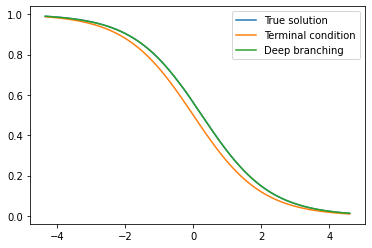

In [21]:
# n = 1
n, T = 1, .5
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    disable_bsde=True, disable_galerkin=True, # verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname=f"burger_{n}",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 34 seconds; L1 error: 2.54E-03; L2 error: 1.57E-05; rel error: 2.32E-02.
fdb runtime: 0 seconds; total runtime: 34 seconds.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 33 seconds; L1 error: 2.81E-03; L2 error: 1.63E-05; rel error: 2.37E-02.
fdb runtime: 0 seconds; total runtime: 33 seconds.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 32 seconds; L1 error: 2.28E-03; L2 error: 1.14E-05; rel error: 1.80E-02.
fdb runtime: 0 seconds; total runtime: 32 seconds.


#### Starting deep branching method with seed 3 - 4 out of 10 times
Time taken: 32 seconds; L1 error: 2.80E-03; L2 error: 1.36E-05; rel error: 2.10E-02.
fdb runtime: 0 seconds; total runtime: 32 seconds.


#### Starting deep branching method with seed 4 - 5 out of 10 times
Time taken: 33 seconds; L1 error: 2.73E-03; L2 error: 1.34E-05; rel error: 2.83E-02.
fdb runtime: 0 seconds;

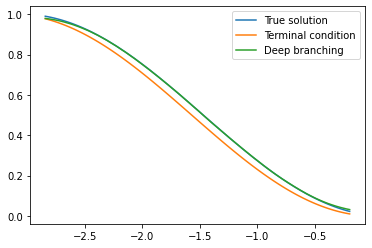

In [22]:
# n = 2
n, T = 2, .2
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    disable_bsde=True, disable_galerkin=True, # verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname=f"burger_{n}",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 43 seconds; L1 error: 1.33E-03; L2 error: 2.83E-06; rel error: 2.94E-03.
fdb runtime: 0 seconds; total runtime: 43 seconds.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 43 seconds; L1 error: 1.14E-03; L2 error: 2.87E-06; rel error: 2.45E-03.
fdb runtime: 0 seconds; total runtime: 43 seconds.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 42 seconds; L1 error: 1.13E-03; L2 error: 3.60E-06; rel error: 2.75E-03.
fdb runtime: 0 seconds; total runtime: 42 seconds.


#### Starting deep branching method with seed 3 - 4 out of 10 times
Time taken: 42 seconds; L1 error: 7.46E-04; L2 error: 1.17E-06; rel error: 1.77E-03.
fdb runtime: 0 seconds; total runtime: 42 seconds.


#### Starting deep branching method with seed 4 - 5 out of 10 times
Time taken: 43 seconds; L1 error: 1.07E-03; L2 error: 2.40E-06; rel error: 2.53E-03.
fdb runtime: 0 seconds;

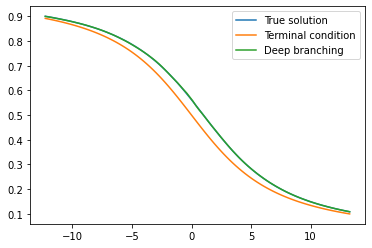

In [23]:
# n = 1/2
n, T = 1/2, 2.
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=n, T=T, eps=1e-3, eps_graph=1e-1)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    disable_bsde=True, disable_galerkin=True, # verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname=f"burger_{n}",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 43 seconds; L1 error: 3.11E-03; L2 error: 1.98E-05; rel error: 9.05E-03.
fdb runtime: 0 seconds; total runtime: 43 seconds.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 43 seconds; L1 error: 2.79E-03; L2 error: 1.57E-05; rel error: 1.10E-02.
fdb runtime: 0 seconds; total runtime: 43 seconds.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 41 seconds; L1 error: 2.19E-03; L2 error: 7.75E-06; rel error: 9.50E-03.
fdb runtime: 0 seconds; total runtime: 41 seconds.


#### Starting deep branching method with seed 3 - 4 out of 10 times
Time taken: 42 seconds; L1 error: 2.45E-03; L2 error: 1.34E-05; rel error: 1.45E-02.
fdb runtime: 0 seconds; total runtime: 42 seconds.


#### Starting deep branching method with seed 4 - 5 out of 10 times
Time taken: 44 seconds; L1 error: 3.03E-03; L2 error: 1.40E-05; rel error: 1.06E-02.
fdb runtime: 0 seconds;

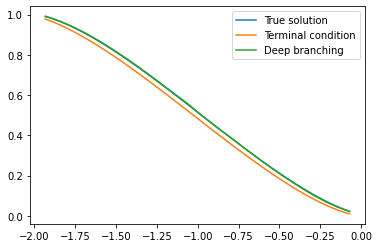

In [24]:
# n = 3
n, T = 3, .1
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=n, T=T)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    disable_bsde=True, disable_galerkin=True, # verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname=f"burger_{n}",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 43 seconds; L1 error: 1.77E-03; L2 error: 9.31E-06; rel error: 3.47E-03.
fdb runtime: 0 seconds; total runtime: 44 seconds.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 43 seconds; L1 error: 1.65E-03; L2 error: 5.70E-06; rel error: 4.35E-03.
fdb runtime: 0 seconds; total runtime: 43 seconds.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 42 seconds; L1 error: 1.39E-03; L2 error: 6.00E-06; rel error: 3.08E-03.
fdb runtime: 0 seconds; total runtime: 42 seconds.


#### Starting deep branching method with seed 3 - 4 out of 10 times
Time taken: 42 seconds; L1 error: 1.34E-03; L2 error: 9.29E-06; rel error: 2.83E-03.
fdb runtime: 0 seconds; total runtime: 42 seconds.


#### Starting deep branching method with seed 4 - 5 out of 10 times
Time taken: 44 seconds; L1 error: 1.73E-03; L2 error: 8.71E-06; rel error: 5.06E-03.
fdb runtime: 0 seconds;

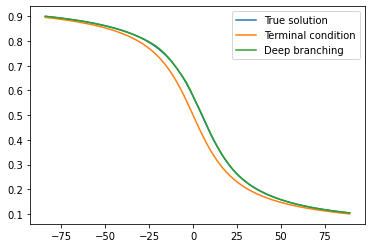

In [25]:
# n = 1/3
n, T = 1/3, 10.
grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal, \
    f_example, deriv_map, phi_example = gen_for_generalized_burgers(n=n, T=T, eps=1e-2, eps_graph=1e-1)
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    disable_bsde=True, disable_galerkin=True, # verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname=f"burger_{n}",
                    branch_nb_states=1000, branch_nb_path_per_state=10000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example)

# d-dimensional PDE

## Allen-Cahn

In [5]:
fixed_dim, dim = 0, 5

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return y[0] - y[0] ** 3

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
def dgm_f_example(y):
    """
    idx 0      -> no deriv
    idx 1 to n -> second deriv
    """
    return .5 * y[1:].sum(axis=0) + y[0] - y[0] ** 3

def phi_example(x):
    return -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T):
    return -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

t_lo, x_lo, x_hi, n = 0., -8., 8., 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 60 seconds; L1 error: 3.45E-03; L2 error: 1.91E-05; rel error: 7.43E-03.
fdb runtime: 0 seconds; total runtime: 60 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 137 seconds; L1 error: 6.03E-03; L2 error: 3.85E-05; rel error: 2.40E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 85 seconds; L1 error: 3.75E-03; L2 error: 2.07E-05; rel error: 1.09E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 55 seconds; L1 error: 3.19E-03; L2 error: 1.68E-05; rel error: 6.49E-03.
fdb runtime: 0 seconds; total runtime: 55 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 131 seconds; L1 error: 3.30E-03; L2 error: 2.38E-05; rel error: 2.30E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 90 seconds; L1 error: 4.45E-03; L2 error: 2.83E-05; rel error

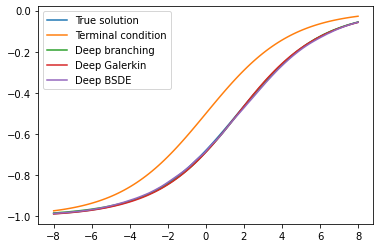

In [6]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_branch=True, disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn",
                    branch_nb_states=1000, branch_nb_path_per_state=100000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=100,
                    bsde_nb_states=100000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Exponential nonlinearity

In [7]:
fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), np.identity(dim)), axis=0).astype(int)
def f_example(y):
    """
    idx 0      -> no deriv
    idx 1 to d -> first deriv
    """
    return alpha/dim*y[1:].sum(dim=0) - 2*dim*torch.exp(-2*y[0]) + dim*torch.exp(-y[0])

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
def dgm_f_example(y):
    """
    idx 0         -> no deriv
    idx 1 to d    -> first deriv
    idx 1+d to 2d -> second deriv
    """
    return .5 * y[(dim+1):].sum(dim=0) + alpha/dim*y[1:(dim+1)].sum(dim=0) - 2*dim*torch.exp(-2*y[0]) + dim*torch.exp(-y[0])

def phi_example(x):
    return torch.log(1 + x.sum(dim=0) ** 2)

def exact_example(t, x, T):
    return np.log(1 + (x.sum(axis=0) + alpha * (T - t)) ** 2)

t_lo, x_lo, x_hi, n = 0., -4., 4., 1
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .05
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 49 seconds; L1 error: 3.15E-02; L2 error: 7.48E-03; rel error: 1.48E+00.
fdb runtime: 0 seconds; total runtime: 49 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 180 seconds; L1 error: 2.36E+00; L2 error: 6.97E+00; rel error: 9.18E+01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 91 seconds; L1 error: 1.89E-02; L2 error: 1.55E-03; rel error: 3.33E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 48 seconds; L1 error: 2.21E-02; L2 error: 2.11E-03; rel error: 8.30E-01.
fdb runtime: 0 seconds; total runtime: 49 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 176 seconds; L1 error: 1.88E+00; L2 error: 4.98E+00; rel error: 8.29E+01.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 91 seconds; L1 error: 1.92E-02; L2 error: 1.37E-03; rel error

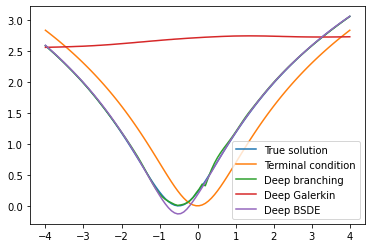

In [8]:
# corrected bn_layer for deep_bsde method
#
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, disable_galerkin=True, disable_bsde=True, disable_branch=True,
                    T=T, device=device, epochs=3000, fname="exponential",
                    branch_nb_states=1000, branch_nb_path_per_state=3000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=100,
                    bsde_nb_states=100000, bsde_nb_time_intervals=4,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Cosine nonlinearity

In [9]:
fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim), 4 * np.identity(dim)), axis=0).astype(int)
def f_example(y):
    """
    idx 0          -> no deriv
    idx 1 to d     -> first deriv
    idx 1+d to 2d  -> second deriv
    idx 1+2d to 3d -> forth deriv
    """
    return -.5 * y[(dim+1):(2*dim+1)].sum(dim=0) + alpha * y[1:(dim+1)].sum(dim=0) / dim + y[0] - (y[(dim+1):(2*dim+1)].sum(dim=0) / 12 / dim) ** 2 + torch.cos(math.pi * y[(2*dim+1):] / 24).sum(dim=0) / dim
    

dgm_deriv_map = deriv_map
def dgm_f_example(y):
    """
    idx 0          -> no deriv
    idx 1 to d     -> first deriv
    idx 1+d to 2d  -> second deriv
    idx 1+2d to 3d -> forth deriv
    """
    return alpha * y[1:(dim+1)].sum(dim=0) / dim + y[0] - (y[(dim+1):(2*dim+1)].sum(dim=0) / 12 / dim) ** 2 + torch.cos(math.pi * y[(2*dim+1):] / 24).sum(dim=0) / dim

def phi_example(x):
    xx = x.sum(dim=0)
    return xx**4 + xx**3 - 36/47 * xx**2 - 24*36/47 * xx + 4 * (36/47)**2

def exact_example(t, x, T):
    xx = x.sum(axis=0) + alpha * (T - t)
    return xx**4 + xx**3 - 36/47 * xx**2 - 24*36/47 * xx + 4 * (36/47)**2

t_lo, x_lo, x_hi, n = 0., -5., 5., 4
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .04
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 534 seconds; L1 error: 1.20E+01; L2 error: 4.75E+02; rel error: 3.04E-01.
fdb runtime: 152 seconds; total runtime: 686 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 717 seconds; L1 error: 2.59E+02; L2 error: 7.88E+04; rel error: 3.10E+01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 276 seconds; L1 error: 9.20E+00; L2 error: 2.56E+02; rel error: 2.19E-01.
fdb runtime: 21 seconds; total runtime: 297 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 709 seconds; L1 error: 2.57E+02; L2 error: 7.77E+04; rel error: 3.08E+01.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 335 seconds; L1 error: 1.29E+01; L2 error: 5.67E+02; rel error: 4.03E-01.
fdb runtime: 85 seconds; total runtime: 420 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
T

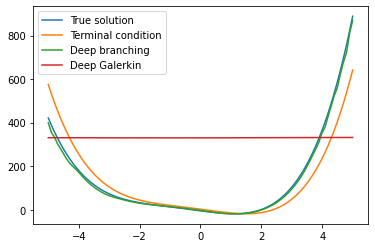

In [10]:
 # Performance comparison
 #
 # choosing one percentile for removal of outlier in the case of branch_nb_path_per_state=50
 # does not completely remove any outlier
 # we have to choose three percentile in this case
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, # seeds=[0],
                    # disable_galerkin=True, verbose=True, debug_mode=True, disable_branch=True,
                    T=T, device=device, epochs=3000, fname="cosine",
                    branch_nb_states=1000, branch_nb_path_per_state=50,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200, outlier_percentile=3,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Log nonlinearity

In [11]:
fixed_dim, dim = 0, 5
alpha = 10

# function definition
deriv_map = np.concatenate((1 * np.identity(dim), 2 * np.identity(dim), 3 * np.identity(dim)), axis=0).astype(int)
def f_example(y):
    """
    idx 0 to d-1   -> first deriv
    idx d to 2d-1  -> second deriv
    idx 2d to 3d-1 -> third deriv
    """
    return -.5 * y[dim:(2*dim)].sum(dim=0) + alpha * y[:dim].sum(dim=0) / dim + torch.log(((y[dim:(2*dim)]**2).sum(dim=0) + (y[(2*dim):]**2).sum(dim=0)) / dim)
    

dgm_deriv_map = deriv_map
def dgm_f_example(y):
    """
    idx 0 to d-1   -> first deriv
    idx d to 2d-1  -> second deriv
    idx 2d to 3d-1 -> third deriv
    """
    return alpha * y[:dim].sum(dim=0) / dim + torch.log(((y[dim:(2*dim)]**2).sum(dim=0) + (y[(2*dim):]**2).sum(dim=0)) / dim)

def phi_example(x):
    return torch.cos(x.sum(dim=0))

def exact_example(t, x, T):
    return np.cos(x.sum(axis=0) + alpha * (T-t))

t_lo, x_lo, x_hi, n = 0., -3., 3., 3
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .02
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 125 seconds; L1 error: 1.70E-01; L2 error: 1.43E+00; rel error: 3.96E-01.
fdb runtime: 40 seconds; total runtime: 165 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 394 seconds; L1 error: 6.41E-01; L2 error: 5.22E-01; rel error: 1.32E+00.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 106 seconds; L1 error: 3.89E-02; L2 error: 2.72E-03; rel error: 1.66E-01.
fdb runtime: 19 seconds; total runtime: 125 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 422 seconds; L1 error: 6.40E-01; L2 error: 5.22E-01; rel error: 1.36E+00.


#### Starting deep branching method with seed 2 - 3 out of 10 times
Time taken: 280 seconds; L1 error: 3.22E-02; L2 error: 2.41E-03; rel error: 1.95E-01.
fdb runtime: 95 seconds; total runtime: 375 seconds.
#### Starting deep galerkin method with seed 2 - 3 out of 10 times
Ti

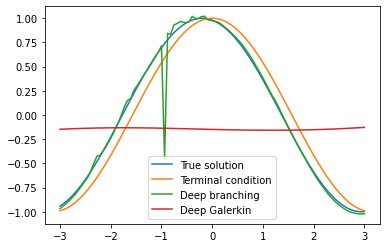

In [12]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, disable_bsde=True, # seeds=[7],
                    # disable_galerkin=True, verbose=True, debug_mode=True, disable_branch=True,
                    T=T, device=device, epochs=3000, fname="log",
                    branch_nb_states=1000, branch_nb_path_per_state=200,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)